<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/Week5/Assignment2/MSDS453_Assignment_02_SUP01_v03_20231006_Sentiment_classification_Doc2Vec_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment analysis experiments (DocVec - 100)
### Submitted by : Vasisvaran Gopal (Vasu)

In [38]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

# Figures inline and set visualization style
%matplotlib inline

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, color_codes=True)
sns.despine()

import warnings
warnings.filterwarnings('ignore')

<Figure size 640x480 with 0 Axes>

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [39]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


In [40]:
sns.set_context('talk')

In [41]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [42]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


#### Uncomment To Map Drive

In [43]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Data

In [44]:
CORPUS_PATH='/content/gdrive/MyDrive/Temp/MSDS453/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus  = get_corpus_df(CORPUS_PATH)

In [45]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [46]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [47]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [48]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [49]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text

In [50]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [51]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [52]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [53]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


### Utility Functions

In [54]:
def show_classification_metics(y_test, y_pred, model):
    print(classification_report(y_test, y_pred))
    fig, ax = plt.subplots(figsize=(4,3), dpi=100)

    conf_matrix = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title='Confusion Matrix for Sentiment Analysis')
    display.plot(ax=ax);

# Feature Extraction

## Method 1: TF-IDF

In [55]:
tfidf_vectorizer = TfidfVectorizer()

In [56]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [57]:
features_tfidf_scores = pd.DataFrame(dtm_class_corpus.toarray(),
                                     columns=tfidf_vectorizer.get_feature_names_out(),
                                     index=class_corpus.index)

In [58]:
features_tfidf_scores.shape

(200, 10079)

## Method 2: Doc2Vec

In [59]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [60]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=100,
                        min_count=1,
                        workers=4)

In [61]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [62]:
features_doc2vec.shape

(200, 100)

In [63]:
### Select vectorization method

In [64]:
method = "TF-IDF"

if method == "Doc2Vec":
    input_features = features_tfidf_scores
else:
    input_features = features_doc2vec

# Sentiment Analysis

In [65]:
labels = class_corpus['Review Type (pos or neg)']

In [66]:
labels.value_counts()

Negative    100
Positive    100
Name: Review Type (pos or neg), dtype: int64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(input_features, labels,
                                                    test_size=0.3,
                                                    random_state=20130810)

As an example, let us train a [support vector machine](https://scikit-learn.org/stable/modules/svm.html) with the default settings.

### Pipeline

In [68]:
# numerical transformer
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', MinMaxScaler()),
    ])

### SVM

In [69]:
# SVM classfier
svm_pipeline = Pipeline([
        ('data', num_pipeline),
        ('svm', SVC(random_state=42))
    ])

In [70]:
# Grid search validation for SVM classifier
params_svm = {
                'svm__C' : [0.01, 0.1, 1, 10, 100, 1000, 10000],
            }

gs_svm = GridSearchCV(svm_pipeline, params_svm, n_jobs=-1, cv=10)

gs_svm.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         MinMaxScaler())])),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100, 1000, 10000]})

In [71]:
print(f"Best Hyperparameter: {gs_svm.best_params_}")

Best Hyperparameter: {'svm__C': 1000}


In [72]:
y_pred = gs_svm.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.58      0.37      0.45        30
    Positive       0.54      0.73      0.62        30

    accuracy                           0.55        60
   macro avg       0.56      0.55      0.53        60
weighted avg       0.56      0.55      0.53        60



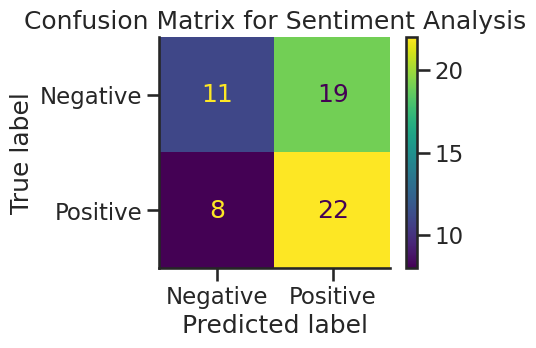

In [73]:
show_classification_metics(y_test, y_pred, gs_svm)

### Random Forest Classifier

In [74]:
# random forest classifier
rf_pipeline = Pipeline([
        ('data', num_pipeline),
        ('rf', RandomForestClassifier(random_state=42))
    ])

In [75]:
# Grid search validation for forest classifier
params_rf = {
                'rf__n_estimators' : [1, 2, 10, 20, 50, 100],
                'rf__max_leaf_nodes': list(range(10,20,2)),
                'rf__criterion': ['gini','entropy'],
                'rf__max_depth': list(range(5,10,1)),
            }

gs_rf = GridSearchCV(rf_pipeline, params_rf, n_jobs=-1, cv=10)

gs_rf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         MinMaxScaler())])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [5, 6, 7, 8, 9],
                         'rf__max_leaf_nodes': [10, 12, 14, 16, 18],
                         'rf__n_estimators': [1, 2, 10, 20, 50, 100]})

In [76]:
print(f"Best Hyperparameter: {gs_rf.best_params_}")

Best Hyperparameter: {'rf__criterion': 'gini', 'rf__max_depth': 7, 'rf__max_leaf_nodes': 14, 'rf__n_estimators': 2}


In [77]:
y_pred = gs_rf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.52      0.53      0.52        30
    Positive       0.52      0.50      0.51        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60



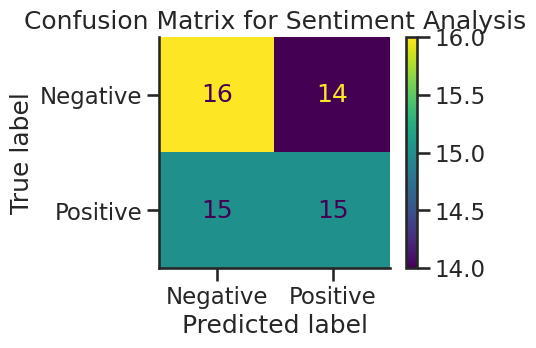

In [78]:
show_classification_metics(y_test, y_pred, gs_rf)

### Logistic Regression

In [79]:
# logistic regression
logistic_pipeline = Pipeline([
        ('data', num_pipeline),
        ('logistic', LogisticRegression(max_iter=10000, random_state=42))
    ])

In [80]:
# Grid search validation for logistic regression
params_logistic = {'logistic__C' : np.logspace(-3,3,7),
                 'logistic__penalty': ['l1','l2'],
                  'logistic__solver': ['liblinear','saga']}

gs_logistic = GridSearchCV(logistic_pipeline, params_logistic, n_jobs=-1, cv=10)

gs_logistic.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         MinMaxScaler())])),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logistic__penalty': ['l1', 'l2'],
                         'logistic__solver': ['liblinear', 'saga']})

In [81]:
print(f"Best Hyperparameter: {gs_logistic.best_params_}")

Best Hyperparameter: {'logistic__C': 100.0, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


In [82]:
y_pred = gs_rf.predict(X_test)

              precision    recall  f1-score   support

    Negative       0.52      0.53      0.52        30
    Positive       0.52      0.50      0.51        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60



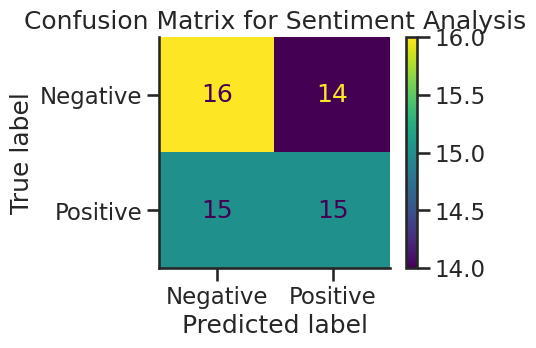

In [83]:
show_classification_metics(y_test, y_pred, gs_logistic)

### Gradient Boosted Trees

In [84]:
# Gradient boosted trees
xgb_pipeline = Pipeline([
        ('data', num_pipeline),
        ('xgb', xgb.XGBClassifier(use_label_encoder = True, eval_metric = 'aucpr',seed = 42))
    ])

In [85]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

In [86]:
# Grid search validation for gradient boosted trees
params_xgb = {
                'xgb__n_estimators' : [200],
                'xgb__max_depth' : list(range(5,10,1)),
                #'xgb__learning_rate' : [0.2, 0.4, 0.6],
                #'xgb__colsample_bytree' : [.7, .8, .9, 1]
             }

gs_xgb = GridSearchCV(xgb_pipeline, params_xgb, n_jobs=-1, cv=10)

gs_xgb.fit(X_train, y_train_le)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('scaler',
                                                         MinMaxScaler())])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric...
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__max_depth': [5, 6, 7, 8, 9],
                         'xgb__n_estimators': [200]})

In [87]:
print(f"Best Hyperparameter: {gs_logistic.best_params_}")

Best Hyperparameter: {'logistic__C': 100.0, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


In [88]:
y_pred = gs_xgb.predict(X_test)

In [89]:
y_test_le = le.fit_transform(y_test)

              precision    recall  f1-score   support

           0       0.42      0.33      0.37        30
           1       0.44      0.53      0.48        30

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.43      0.43      0.43        60



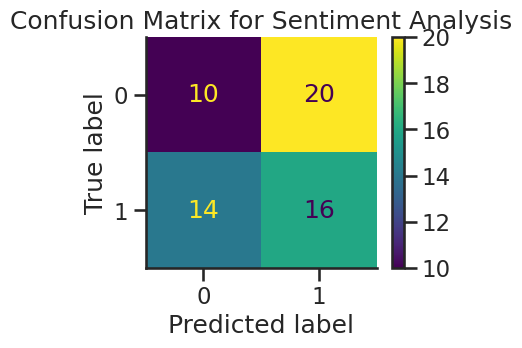

In [90]:
show_classification_metics(y_test_le, y_pred, gs_xgb)

### Ensemble models

In [91]:
# Define the base models
level0 = list()
level0.append(('svm', svm_pipeline))
level0.append(('rf', rf_pipeline))
level0.append(('xgb', xgb_pipeline))

# Define meta learner model
level1 = LogisticRegression(max_iter=10000, random_state=42)

# Define the stacking ensemble
stacked_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)

In [92]:
gs_stacked = GridSearchCV(estimator=stacked_model,
                    param_grid={},
                    cv=10,
                    refit=True)
gs_stacked.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10,
             estimator=StackingClassifier(cv=10,
                                          estimators=[('svm',
                                                       Pipeline(steps=[('data',
                                                                        Pipeline(steps=[('imputer',
                                                                                         SimpleImputer(strategy='median')),
                                                                                        ('scaler',
                                                                                         MinMaxScaler())])),
                                                                       ('svm',
                                                                        SVC(random_state=42))])),
                                                      ('rf',
                                                       Pipeline(steps=[('data',
                                                                        Pipeline(steps=[('imputer',
                                                                                         SimpleImputer(strategy='median')),
                                                                                        ('scaler',
                                                                                         MinMaxScaler())])),
                                                                       ('rf',
                                                                        Rando...
                                                                                      max_bin=None,
                                                                                      max_cat_threshold=None,
                                                                                      max_cat_to_onehot=None,
                                                                                      max_delta_step=None,
                                                                                      max_depth=None,
                                                                                      max_leaves=None,
                                                                                      min_child_weight=None,
                                                                                      missing=nan,
                                                                                      monotone_constraints=None,
                                                                                      multi_strategy=None,
                                                                                      n_estimators=None,
                                                                                      n_jobs=None,
                                                                                      num_parallel_tree=None,
                                                                                      random_state=None, ...))]))],
                                          final_estimator=LogisticRegression(max_iter=10000,
                                                                             random_state=42)),
             param_grid={})

In [93]:
y_pred = gs_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.42      0.33      0.37        30
           1       0.44      0.53      0.48        30

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.43      0.43      0.43        60



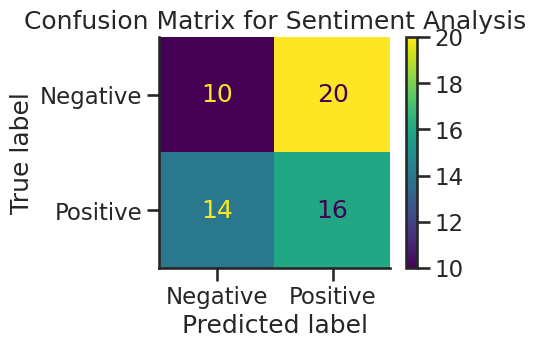

In [94]:
show_classification_metics(y_test_le, y_pred, gs_stacked)

# Conclusion

When text is an input to a supervised learning task (e.g., sentiment analysis or multi-class prediction) detailed examination of the classification metrics helps select the appropriate feature engineering process.